# Progetto di Ricerca Operativa: Piano di Evacuazione per i Campi Flegrei

**Obiettivo:** Sviluppare un piano di evacuazione per l'area dei Campi Flegrei utilizzando il modello del **Flusso più Rapido (Quickest Flow)**.

**Metodologia:** L'approccio si basa sulla teoria presentata nel paper "Quickest Flows Over Time" di Fleischer e Skutella. Poiché il problema generale è NP-hard, implementeremo l'**algoritmo di 2-approssimazione** descritto nella Sezione 3. Questo approccio riduce il complesso problema dinamico a una serie di problemi di **flusso statico a costo minimo**, risolvibili efficientemente.

## Fase 1: Modellazione Matematica

In questa sezione, formalizziamo il problema utilizzando la notazione matematica standard per i flussi su rete.

### 1.1 Insiemi e Indici

- $V$: Insieme dei **nodi** della rete (incroci, città).
- $A$: Insieme degli **archi** orientati $(i, j)$ che rappresentano i tratti stradali, dove $i, j \in V$.
- $S \subset V$: Sottoinsieme dei nodi che sono **sorgenti** (centri abitati da evacuare).
- $P \subset V$: Sottoinsieme dei nodi che sono **pozzi** (aree sicure, uscite dalla zona rossa).

### 1.2 Parametri del Modello

- $D_v$: **Popolazione** (o domanda) da evacuare dal nodo sorgente $v \in S$. Si assume $D_v > 0$.
- $D_{total}$: Popolazione totale da evacuare, $D_{total} = \sum_{v \in S} D_v$.
- $u_e$: **Capacità** dell'arco $e \in A$ (es. veicoli per ora).
- $\tau_e$: **Tempo di transito** per percorrere l'arco $e \in A$ (es. in ore).

### 1.3 Il Problema del Flusso più Rapido (Quickest Flow)

Il problema originale consiste nel trovare il tempo minimo $T$ per inviare l'intera popolazione $D_{total}$ dalle sorgenti $S$ ai pozzi $P$. Questo richiede la definizione di variabili di flusso dinamiche $f_e(t)$ che dipendono dal tempo, rendendo il problema molto complesso.

### 1.4 L'Approccio di Approssimazione: Riduzione a Flusso Statico a Costo Minimo

Seguendo il paper di Fleischer e Skutella, invece di risolvere il problema dinamico, lo approssimiamo con un modello statico più semplice. L'idea è trovare un piano di flusso che minimizzi il "tempo di viaggio totale" accumulato da tutte le persone evacuate. Questo modello viene risolto all'interno di una ricerca binaria sul tempo totale di evacuazione $T$.

#### Variabili di Decisione (Statiche)

- $x_e$: **Flusso** statico sull'arco $e \in A$ (numero totale di persone/veicoli che usano l'arco durante l'intera evacuazione).

#### Formulazione del Flusso a Costo Minimo

Per ogni tempo candidato $T$ nella nostra ricerca binaria, risolviamo il seguente problema di ottimizzazione:

**Obiettivo:** Minimizzare il tempo di viaggio aggregato.
$$ \min Z = \sum_{e \in A} \tau_e \cdot x_e $$

**Sotto i vincoli:**

1.  **Conservazione del Flusso:** Per ogni nodo $i \in V$, il flusso netto deve eguagliare l'offerta/domanda del nodo.
    $$ \sum_{j : (j,i) \in A} x_{ji} - \sum_{j : (i,j) \in A} x_{ij} = -b_i \quad \forall i \in V $$
    dove:
    - $b_i = D_i$ se $i \in S$ (offerta).
    - $b_i = -\frac{D_{total}}{|P|}$ se $i \in P$ (domanda, distribuita sui pozzi).
    - $b_i = 0$ altrimenti (nodo di transito).

2.  **Capacità degli Archi:** Il flusso su un arco non può superare la sua capacità. *Attenzione: la capacità del modello statico è legata al tempo $T$. La capacità istantanea $u_e$ (veicoli/ora) diventa una capacità totale $u_e \cdot T$ sull'intero orizzonte temporale.*
    $$ 0 \le x_e \le u_e \cdot T \quad \forall e \in A $$

### 1.5 Framework della Ricerca Binaria

1. Inizializza un intervallo di tempo $[T_{min}, T_{max}]$.
2. Fintanto che $T_{max} - T_{min}$ è maggiore di una tolleranza:
   a. Calcola un tempo di prova $T_{guess} = (T_{min} + T_{max}) / 2$.
   b. Risolvi il problema di Flusso a Costo Minimo definito sopra, usando $T_{guess}$ per calcolare le capacità totali degli archi.
   c. Se il problema è **infattibile**, significa che le capacità non sono sufficienti per far passare il flusso in tempo $T_{guess}$. Quindi, $T_{guess}$ è troppo basso. Aggiorna $T_{min} = T_{guess}$.
   d. Se il problema è **fattibile**, abbiamo un piano. Non usiamo il costo per la decisione nella ricerca binaria, ma solo la fattibilità. Significa che un piano esiste per $T_{guess}$. Proviamo a ridurlo. Aggiorna $T_{max} = T_{guess}$.
3. Il risultato è $T_{max}$, una stima del tempo minimo di evacuazione.

## Fase 2: Implementazione in Python con Gurobi

Ora traduciamo il modello matematico in codice Python.

In [1]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt

### 3. Definizione dei Dati di Esempio

Creiamo un piccolo grafo di esempio per testare il nostro modello. **Questa è la sezione che dovrai sostituire con i tuoi dati reali** ottenuti da OpenStreetMap (con OSMnx) e ISTAT.

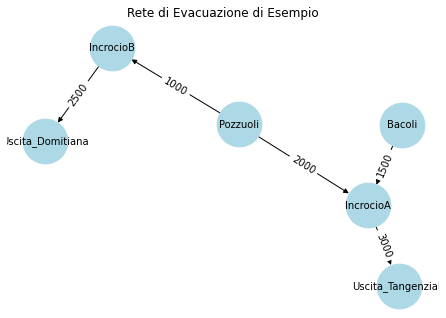

In [2]:
# 1. Creare un grafo di esempio con NetworkX
G = nx.DiGraph()

# Aggiungi archi con attributi: capacità (veicoli/ora) e tempo di transito tau (ore)
G.add_edge('Pozzuoli', 'IncrocioA', capacity=2000, tau=0.2) # 12 minuti
G.add_edge('Bacoli', 'IncrocioA', capacity=1500, tau=0.3)
G.add_edge('IncrocioA', 'Uscita_Tangenziale', capacity=3000, tau=0.1)
G.add_edge('Pozzuoli', 'IncrocioB', capacity=1000, tau=0.4)
G.add_edge('IncrocioB', 'Uscita_Domitiana', capacity=2500, tau=0.5)

# 2. Definire sorgenti e pozzi
population_sources = {'Pozzuoli': 50000, 'Bacoli': 20000}
sink_nodes = ['Uscita_Tangenziale', 'Uscita_Domitiana']

# Visualizza il grafo per un controllo
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10)
edge_labels = nx.get_edge_attributes(G, 'capacity')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Rete di Evacuazione di Esempio")
plt.show()

### 4. Funzione per Risolvere il Flusso Statico (Gurobi)

Questa funzione implementa il modello di flusso a costo minimo descritto matematicamente sopra. Prende in input il tempo candidato $T$ per calcolare le capacità totali.

In [ ]:
def solve_static_flow(graph, supplies, T):
    """
    Risolve il problema del flusso a costo minimo per un dato orizzonte temporale T.
    """
    model = gb.Model("StaticFlowForEvacuation")

    # Variabili: flusso su ogni arco
    x = model.addVars(graph.edges(), name="flow", lb=0)

    # Obiettivo: minimizzare il costo (tempo di viaggio totale)
    model.setObjective(
        gb.quicksum(graph.edges[u, v]['tau'] * x[u, v] for u, v in graph.edges()),
        gb.GRB.MINIMIZE
    )

    # Vincoli di capacità totale per l'orizzonte T
    model.addConstrs(
        (x[u, v] <= graph.edges[u, v]['capacity'] * T for u, v in graph.edges()),
        name="capacity"
    )

    # Vincoli di conservazione del flusso
    for node in graph.nodes():
        flow_out = gb.quicksum(x[node, v] for u, v in graph.out_edges(node))
        flow_in = gb.quicksum(x[u, node] for u, v in graph.in_edges(node))
        supply = supplies.get(node, 0)
        model.addConstr((flow_out - flow_in == supply), name=f"flow_conservation_{node}")

    model.setParam('OutputFlag', 0)
    model.optimize()

    if model.Status == gb.GRB.OPTIMAL:
        flow_plan = {uv: x[uv].X for uv in x}
        return True, flow_plan # Restituisce la fattibilità e il piano
    else:
        return False, None # Il problema è infattibile per questo T

### 5. Algoritmo di Ricerca Binaria

Questa funzione principale orchestra il processo, chiamando il solutore Gurobi all'interno del loop di ricerca.

In [ ]:
def find_quickest_evacuation_time(graph, population_sources, sink_nodes):
    total_population = sum(population_sources.values())

    supplies = {node: pop for node, pop in population_sources.items()}
    if sink_nodes:
        demand_per_sink = -total_population / len(sink_nodes)
        for node in sink_nodes:
            supplies[node] = demand_per_sink

    print(f"Inizio ricerca del tempo di evacuazione per {total_population} persone.")

    # Stime iniziali per T
    T_min = 0
    T_max = 24 # Limite superiore iniziale (es. 24 ore)

    # Prima verifichiamo se T_max è fattibile, altrimenti lo aumentiamo
    is_feasible, _ = solve_static_flow(graph, supplies, T_max)
    while not is_feasible:
        print(f"Il limite superiore T_max={T_max} ore non è sufficiente. Raddoppio.")
        T_max *= 2
        is_feasible, _ = solve_static_flow(graph, supplies, T_max)

    print(f"Trovato un limite superiore fattibile: {T_max} ore. Inizio ricerca binaria.")

    tolerance = 0.01 # Tolleranza in ore (circa 36 secondi)
    optimal_time = T_max
    final_flow_plan = None

    for i in range(100): # Limita le iterazioni per sicurezza
        if T_max - T_min <= tolerance:
            break

        T_guess = (T_min + T_max) / 2
        print(f"Iterazione {i+1}: Intervallo [{T_min:.2f}, {T_max:.2f}], Tento T = {T_guess:.2f}")

        is_feasible, flow_plan = solve_static_flow(graph, supplies, T_guess)

        if is_feasible:
            # Se fattibile, T_guess diventa il nuovo massimo e salviamo la soluzione
            T_max = T_guess
            optimal_time = T_guess
            final_flow_plan = flow_plan
        else:
            # Se non fattibile, T_guess è troppo basso
            T_min = T_guess

    return optimal_time, final_flow_plan

### 6. Esecuzione e Analisi dei Risultati

In [6]:
best_time, evacuation_plan = find_quickest_evacuation_time(G, population_sources, sink_nodes)

if best_time is not None:
    print("\n--- PIANO DI EVACUAZIONE TROVATO ---")
    print(f"Tempo di evacuazione stimato: {best_time:.2f} ore")
    print("Nota: Questo è il risultato della 2-approssimazione. Il tempo ottimale reale non è superiore a questo valore, e non è inferiore a best_time/2.")

    print("\nFlusso totale per ogni strada (persone/veicoli sull'intero periodo):")
    total_flow_out = 0
    for (u, v), flow_val in evacuation_plan.items():
        if flow_val > 1e-6: # Mostra solo gli archi usati
            capacity_total = G.edges[u,v]['capacity'] * best_time
            saturation = (flow_val / capacity_total) * 100
            print(f"  - Da {u} a {v}: {flow_val:.0f} persone [Saturazione: {saturation:.1f}%]")
            if u in population_sources:
                total_flow_out += flow_val

    print(f"\nFlusso totale in uscita dalle sorgenti: {total_flow_out:.0f}")
    print(f"Popolazione totale da evacuare: {sum(population_sources.values())}")
else:
    print("Non è stato possibile trovare un piano di evacuazione.")

Inizio ricerca del tempo di evacuazione per 70000 persone.
Set parameter Username
Set parameter LicenseID to value 2633434
Academic license - for non-commercial use only - expires 2026-03-07
Il limite superiore T_max=24 ore non è sufficiente. Raddoppio.
Trovato un limite superiore fattibile: 48 ore. Inizio ricerca binaria.
Iterazione 1: Intervallo [0.00, 48.00], Tento T = 24.00
Iterazione 2: Intervallo [24.00, 48.00], Tento T = 36.00
Iterazione 3: Intervallo [24.00, 36.00], Tento T = 30.00
Iterazione 4: Intervallo [30.00, 36.00], Tento T = 33.00
Iterazione 5: Intervallo [33.00, 36.00], Tento T = 34.50
Iterazione 6: Intervallo [34.50, 36.00], Tento T = 35.25
Iterazione 7: Intervallo [34.50, 35.25], Tento T = 34.88
Iterazione 8: Intervallo [34.88, 35.25], Tento T = 35.06
Iterazione 9: Intervallo [34.88, 35.06], Tento T = 34.97
Iterazione 10: Intervallo [34.97, 35.06], Tento T = 35.02
Iterazione 11: Intervallo [34.97, 35.02], Tento T = 34.99
Iterazione 12: Intervallo [34.99, 35.02], Tento

### 7. Conclusioni e Sviluppi Futuri

Questo notebook ha implementato un algoritmo di 2-approssimazione per il problema del flusso più rapido, fornendo un piano di evacuazione e una stima del tempo necessario.

**Come interpretare i risultati:**
- Il **tempo di evacuazione** è la stima del tempo minimo necessario per completare l'operazione.
- Il **piano di flusso** indica quante persone/veicoli dovrebbero percorrere ogni strada durante l'intera evacuazione.
- La **saturazione** è l'indicatore più importante: strade con saturazione vicina al 100% sono i **colli di bottiglia** del sistema. Qualsiasi intervento per migliorare i tempi di evacuazione dovrebbe concentrarsi su queste strade.

**Sviluppi futuri:**
1. **Integrazione Dati Reali:** Sostituire il grafo di esempio con i dati reali della rete stradale dei Campi Flegrei (da OSMnx) e della popolazione (da ISTAT).
2. **Visualizzazione Geografica:** Usare `Folium` o `GeoPandas` per visualizzare il piano di evacuazione su una mappa, colorando le strade in base al flusso o alla saturazione.
3. **Modello più Avanzato:** Considerare estensioni come l'evacuazione per fasi (non tutti partono contemporaneamente) o l'inclusione di diverse modalità di trasporto.
4. **Implementazione FPTAS:** Per una maggiore precisione, si potrebbe implementare l'approccio FPTAS dalla Sezione 4 del paper di Fleischer e Skutella, costruendo la rete condensata espansa nel tempo.